In [1]:
import urllib3
import os
import requests
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import time
from lxml import etree
import re
import math
import csv
import sys

In [2]:
requests.adapters.DEFAULT_RETRIES =20
from requests.packages.urllib3.exceptions import InsecureRequestWarning
# 禁用不安全请求警告
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# 本地准备工作 
1. 创建存储相关路径
2. 记录大类，小类结构和常用url
3. 配置爬虫头文件
4. 下载/读取本地数据首页

In [3]:
lsdir = os.listdir('.')
if 'html_doc' not in lsdir:
    os.mkdir('./html_doc')
if 'dataset' not in lsdir:
    os.mkdir('./dataset')
os.chmod('./html_doc',0o777)
aim = 'hug_dataset'
# 下载好的网页文件
html_path = os.path.join(os.getcwd(),'html_doc')
# 解析后的数据文件
web_path = os.path.join(os.getcwd(),'dataset')
# 数据简介
viewer_path = os.path.join(os.getcwd(),'viewer')

In [4]:
# 路由仓库
URL_HUB = dict()
# 分类后的仓库
URL_HUB_class = dict()
# 数据仓库
URL_DATA_HUB = dict()
# 文档仓库
HTML_DOC = dict()
URL_HUB['hug'] = r'https://huggingface.co/'
URL_HUB['hug_dataset'] = r'https://huggingface.co/datasets'

In [5]:
headers = {
        'User-Agent':r'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'
    }
proxies = {
    "http": "http://127.0.0.1:7890",
    "https": "http://127.0.0.1:7890",
}

In [6]:
if os.path.exists(r'Hugging _dataset.html'):
    with open(r'Hugging _dataset.html','r',encoding='utf-8') as f:
        dataset_html = f.read()
else:
    dataset_web_respond = requests.get(url=URL_HUB['hug_dataset'],verify=False)
    dataset_html = dataset_web_respond.text
soup = bs(dataset_html,'html.parser')

## 解析大小类标签

通过html文件解析找到有关大类小类标签，由于是超链接标签\<a\>所以可以读取href获得url

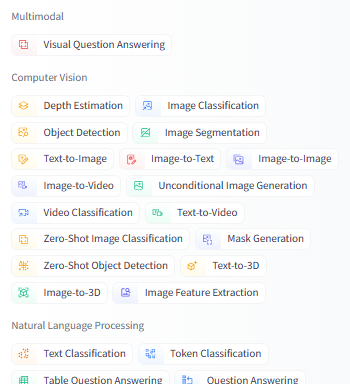

In [7]:
tags = soup.select('div.mb-20')[0].contents
btags = []
for i in tags:
    try:
        if 'mb-3' in i.get('class'):
            btags.append(i)
    except Exception:
        pass
bdic = dict()
for btag in btags:
    blabel = btag.div.string.rstrip('\t').rstrip('\n')
    sdic = dict()
    for a in btag.find_all('a'):
        url = a.get('href')
        slabel = a.span.string
        sdic[slabel] = 'https://huggingface.co' + url
        print(slabel,sdic[slabel])
    bdic[blabel] = sdic

Visual Question Answering https://huggingface.co/datasets?task_categories=task_categories%3Avisual-question-answering
Depth Estimation https://huggingface.co/datasets?task_categories=task_categories%3Adepth-estimation
Image Classification https://huggingface.co/datasets?task_categories=task_categories%3Aimage-classification
Object Detection https://huggingface.co/datasets?task_categories=task_categories%3Aobject-detection
Image Segmentation https://huggingface.co/datasets?task_categories=task_categories%3Aimage-segmentation
Text-to-Image https://huggingface.co/datasets?task_categories=task_categories%3Atext-to-image
Image-to-Text https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-text
Image-to-Image https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-image
Image-to-Video https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-video
Unconditional Image Generation https://huggingface.co/datasets?task_categories=task_catego

In [8]:
for k,v in bdic.items():
    print(k)
    for i,(kk,vv) in enumerate(v.items()):
        print(i,kk,vv)

Multimodal
0 Visual Question Answering https://huggingface.co/datasets?task_categories=task_categories%3Avisual-question-answering
Computer Vision
0 Depth Estimation https://huggingface.co/datasets?task_categories=task_categories%3Adepth-estimation
1 Image Classification https://huggingface.co/datasets?task_categories=task_categories%3Aimage-classification
2 Object Detection https://huggingface.co/datasets?task_categories=task_categories%3Aobject-detection
3 Image Segmentation https://huggingface.co/datasets?task_categories=task_categories%3Aimage-segmentation
4 Text-to-Image https://huggingface.co/datasets?task_categories=task_categories%3Atext-to-image
5 Image-to-Text https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-text
6 Image-to-Image https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-image
7 Image-to-Video https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-video
8 Unconditional Image Generation https://hugg

# 相关函数

## 数据页处理相关函数
- find_url
   可以找到页面中的相关数据链接

   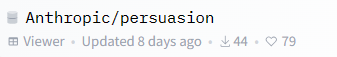

- find_cnt
   可以找到页面中的数据集总量，一页数据页中有三十个小数据集，则总量//30
   为需要查询页数
   可通过在get请求时传参来进行访问数据页

    https://huggingface.co/datasets?task_categories=task_categories:image-classification&p=2&sort=trending

   p=2为参数

   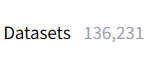
- download_web
   下载网页，使用try高效避免下载错误
   若最终任然无法下载，则记录
   根据本地是否有相关文件来判断是否重复下载，解决记录问题

- download_web_page
   下载小类数据页，随后使用find_cnt计算出当前小类的总页数，通过在请求中设置p=x访问每一页

In [9]:
# 小类数据页处理
def find_url(docdir):
    """
    找到path中所有url
    """
    ans = dict()
    with open(docdir,'br') as f:
        dataset_web_respond = f.read()
    soup = bs(dataset_web_respond,'lxml')
    h4_labels = soup.find_all('h4')

    for h4_lable in h4_labels:
        h4_lable = h4_lable.string
        ans[h4_lable] = URL_HUB['hug_dataset'] + '/' + str(h4_lable)
    return ans

def find_cnt(doc):
    """
    获取小类数据总数
    """
    soup = bs(doc)
    # num = soup.select('.ml-3.w-16.font-normal.text-gray-400').string
    tim = soup.find('div',attrs={
        'class':"ml-3 w-16 font-normal text-gray-400"
    }).string.replace(',','')
    print(tim)
    return math.ceil(int(tim)/30)

def download_web(url,path):
    """
    web路径,本地路径
    下载url网页到指定文件夹下
    """
    if not os.path.exists(path):
        try:
            respond = requests.get(url,verify=False,headers={'Connection':'close'}).text
            with open(path,'bw') as f:
                f.write(respond.encode('utf-8'))
        except Exception as e:
            flag = 0
            for i in range(300):
                try:
                    respond = requests.get(url,verify=False,headers={'Connection':'close'}).text
                    with open(path,'bw') as f:
                        f.write(respond.encode('utf-8'))
                except Exception:
                    if i != 299:
                        time.sleep(0.01)
                    else:
                        print('ERROR:',e)
                        print('ERROR',url,path)
                        return False
                else:
                    break
        else:
            pass
    else:
        pass
    return True


def download_web_page(url,path):
    download_web(url,path[:-5]+'0'+path[-5:])
    with open(path[:-5]+'0'+path[-5:], 'rb') as f:
        doc_page = f.read()
    tim = find_cnt(doc_page)
    for i in range(1,tim):
        download_web(url+'&p='+str(i),path[:-5]+str(i)+path[-5:])
        # https://huggingface.co/datasets?task_categories=task_categories:depth-estimation&p=12&sort=trending

## 抽取数据所需函数
- str2num
    文本形式字符串转数字，将其中的,等特殊符号去掉
- 抽取数据
    find_page_link
    find_download_time
    find_dataset_numb
    find_dataset_size
    find_dataset_viewer
    传入文本，通过正则，解析，字符串操作等手段获取信息

- aio
    整合前面函数，返回包含相关信息的字典

In [10]:
# 搜索数据细节函数
def str2num(s):
    try:
        return eval(s.replace(',','').replace('\\n','').replace('\\t',''))
    except Exception as e:
        # print('ERRORs2n:',s,e)
        return s

def find_page_link(html_doc):
    """
    页面链接
    """
    try:
        soup = bs(html_doc,'lxml')
        label = soup.select('.max-w-full>a')[0]
        url = 'https://huggingface.co' + label.get('href')
        return url
    except Exception:
        return -1

def find_download_time(html_doc):
    try:
        dom = etree.HTML(html_doc)
        download_time = -1
        download_time = dom.xpath('/html/body/div/main/div[2]/section[2]/dl/dd/text()')[0]
    except Exception:
        return -1
    return str2num(download_time)

def find_dataset_numb(html_doc):
    try:
        index_1 = html_doc.rfind('Number of rows')
        index_2 = html_doc[index_1:].find('<!-- HTML_TAG_START -->') + len('<!-- HTML_TAG_START -->')
        index_3 = html_doc[index_1:].find('<!-- HTML_TAG_END -->')
        ret = html_doc[index_1:][index_2:index_3]
        return str2num(ret)
    except Exception: 
        return -1
    
    
def find_dataset_size(html_doc:str):
    try:
        soup = bs(html_doc,'lxml')
        labels = [x.text for x in soup.select('div.truncate.text-sm')]
        re_num = -1
        for label in labels:
            if 'B' in label:
                re = label
                re_num = str2num(re[0:re.find('B')-2])
                if 'K' in re:
                    re_num = re_num / 1024
                elif 'M' in re:
                    re_num = re_num
                elif 'G' in re:
                    re_num = re_num * 1024
                elif 'T' in re:
                    re_num = re_num * 1024 * 1024
                else:
                    re_num = re_num / (1024 * 1024)
                return re_num
        return -1
    except Exception:
        return -1


def find_dataset_viewer(file_name,html_doc):
    try:
        soup = bs(html_doc,'lxml')
        dom = etree.HTML(html_doc)
        try:
            dataset_numb = dom.xpath('/html/body/div/main/div[2]/section[1]/div[5]/div')[0]
        except Exception:
            dataset_numb = dom.xpath('/html/body/div/main/div[2]/section[1]/div[4]')[0]
        text = etree.tostring(dataset_numb)
        soup_ = bs(text,'lxml').html.body
        p = soup_
        writeinner = soup_.get_text()
        text = re.sub(r'[\r\n]+', '\n', writeinner)
        with open(os.path.join(viewer_path,file_name+'.html'),'bw') as f:
            f.write(text.encode('utf-8'))
    except Exception:
        pass
    finally:
        return(os.path.join(viewer_path,file_name+'.html'))
    

def find_dataset_viewer2(html_doc):
    try:
        soup = bs(html_doc,'lxml')
        dom = etree.HTML(html_doc)
        try:
            dataset_numb = dom.xpath('/html/body/div/main/div[2]/section[1]/div[5]/div')[0]
        except Exception:
            dataset_numb = dom.xpath('/html/body/div/main/div[2]/section[1]/div[4]')[0]
        text = etree.tostring(dataset_numb)
        soup_ = bs(text,'lxml').html.body
        p = soup_
        writeinner = soup_.get_text()
        text = re.sub(r'[\r\n]+', '\n', writeinner)
    except Exception:
        return -1
    finally:
        return text
    
def aio(html_doc):
    page_link = find_page_link(html_doc)
    download_time = find_download_time(html_doc)
    dataset_numb = find_dataset_numb(html_doc)
    dataset_size = find_dataset_size(html_doc)
    dataset_viewer = find_dataset_viewer2(html_doc)
    ans = {
        'page_link':page_link,
        'download_time':download_time,
        'dataset_numb':dataset_numb,
        'dataset_size':dataset_size,
        'dataset_viewer':dataset_viewer
    }
    return ans

# 爬取页面

## 下载所有小类网页文件
在html_doc路径下创建大类-小类目录，并在小类目录下下载小类界面文件，如[example](https://huggingface.co/datasets?task_categories=task_categories:text-to-image&sort=trending)

download_web_page可以计算小类的数据量，除以30后即为当前小类网页的张数，由p=x逐一访问

下载完成后重新下载失败的文件

In [11]:
# 下载所有小类网页文件
down_error = []
for blabel,aas in bdic.items():
    # 大类文件
    blabel=blabel.replace(' ','_').replace('/','_').replace('\\','_')
    blabel = os.path.join(html_path,blabel)
    if os.path.exists(blabel) == False:
        os.mkdir(blabel)
    print(blabel)
    for i,(slabel,url) in enumerate(aas.items()):
        # 小类文件
        slabel=slabel.replace(' ','_').replace('/','_').replace('\\','_')
        pw_path = os.path.join(blabel,slabel)
        if os.path.exists(pw_path) == False:
            os.mkdir(pw_path)
        print(i,slabel,url)
        try:
            if not download_web_page(url,os.path.join(pw_path,slabel+'.html')):
                down_error.append([url,pw_path])
        except Exception as e:
            print('ERROR:下载小类网页文件',url,e)
            break
        else:
            pass
for i in range(len(down_error)):
    url,pw_path = down_error[i]
    while not download_web(url,os.path.join(pw_path,slabel+'.html')):
        pass

c:\Users\Elysia\Desktop\learn\课件\二下\python\lab_2\html_doc\Multimodal
0 Visual_Question_Answering https://huggingface.co/datasets?task_categories=task_categories%3Avisual-question-answering
124
c:\Users\Elysia\Desktop\learn\课件\二下\python\lab_2\html_doc\Computer_Vision
0 Depth_Estimation https://huggingface.co/datasets?task_categories=task_categories%3Adepth-estimation
16
1 Image_Classification https://huggingface.co/datasets?task_categories=task_categories%3Aimage-classification
804
2 Object_Detection https://huggingface.co/datasets?task_categories=task_categories%3Aobject-detection
444
3 Image_Segmentation https://huggingface.co/datasets?task_categories=task_categories%3Aimage-segmentation
293
4 Text-to-Image https://huggingface.co/datasets?task_categories=task_categories%3Atext-to-image
3699
5 Image-to-Text https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-text
367
6 Image-to-Image https://huggingface.co/datasets?task_categories=task_categories%3Aimage-to-image

## 通过下载数据信息
find_url可以通过下载到的小类界面可以找到每一个数据库的url

通过将下载到的数据保存在本地对应大类-小类-doc-数据名.html结构的路径下，与下载函数download_web配合来避免重复下载

最后再次将没下载到的数据重新下载

In [12]:
# 下载所有数据
down_error = []

# 查询网页中的数据
bdirs = os.listdir(html_path)
for bdir in tqdm(bdirs):
    # 打开大类文件夹
    print(bdir) 
    bdir = os.path.join(html_path,bdir)
    sdirs = os.listdir(bdir)
    # print(sdirs)
    for sdir in sdirs:
        # 逐个搜索小类文件夹,sdirs为小类集合
        sdocs = os.listdir(os.path.join(bdir,sdir))
        print(' ',sdir)
        for sdoc in sdocs:
            if '.html' not in sdoc:
                "跳过doc文件"
                continue
            sdoc = os.path.join(bdir,sdir,sdoc)
            # # 找到小类网页中的所有数据库
            # print('  ',sdoc)
            url_doc = find_url(sdoc)
            # print('  ',url_doc)
            doc_path = os.path.join(bdir,sdir,'doc')
            if not os.path.exists(doc_path):
                os.mkdir(doc_path)
            for name,url in url_doc.items():
                name = name.replace(' ','_').replace('/','_').replace('\\','_')
                # print(name,url)
                doc_path_i = os.path.join(doc_path,name+'.html')
                if not os.path.exists(doc_path_i):
                    if not download_web(url,doc_path_i):
                        down_error.append([url,doc_path_i])
            # url_doc.clear()

for i in range(len(down_error)):
    url,pw_path = down_error[i]
    while not download_web(url,os.path.join(pw_path,slabel+'.html')):
        pass

  0%|          | 0/7 [00:00<?, ?it/s]

Audio
  Audio-to-Audio
  Audio_Classification


  0%|          | 0/7 [00:10<?, ?it/s]


KeyboardInterrupt: 

# 数据写入

通过相关的csv库写入抽取的数据，得益于保存数据所采用的目录，可以轻松的获得大小类

In [13]:
# 查询数据详细信息
# data.csv
bdirs = os.listdir(html_path)
data_path = os.path.join(viewer_path,'data.csv')
f = open(data_path,'w',encoding='utf-8')
fieldnames = ['dataset_viewer','page_link','download_time','dataset_size','dataset_numb','bclass','sclass']
writer = csv.DictWriter(f,fieldnames=fieldnames)
writer.writeheader()
for bdir in tqdm(bdirs):
    # 打开大类文件夹
    # print(bdir)
    bdirs = os.path.join(html_path,bdir)
    # 大类
    print(bdir) 
    sdirs = os.listdir(bdirs)
    sdirs = [x for x in sdirs if '.html' not in x]
    # # print(sdirs)
    for sdir in sdirs:
    #     # 逐个搜索小类文件夹,sdirs为小类集合
        # 小类
        print(' ',sdir)
        sdir_path = os.path.join(bdirs,sdir,'doc')
        sdocs = os.listdir(sdir_path)
        for sdoc in sdocs:
            # 数据名
            # print('  ',sdoc)
            sdoc_path = os.path.join(sdir_path,sdoc)
            # print(' ',sdoc_path)
            with open(sdoc_path,'br') as f:
                text = f.read()
            try:
                text = str(text)
                info_dic = aio(text)
                if info_dic['page_link']==-1:
                    info_dic['page_link']='NET_ERROR'
                info_dic['bclass'] = bdir
                info_dic['sclass'] = sdir
                writer.writerow(info_dic)
            except Exception as e:
                pass
f.close()

  0%|          | 0/7 [00:00<?, ?it/s]

Audio
  Audio-to-Audio
  Audio_Classification
  Automatic_Speech_Recognition
  Text-to-Audio
  Text-to-Speech
  Voice_Activity_Detection


 14%|█▍        | 1/7 [01:23<08:22, 83.81s/it]

Computer_Vision
  Depth_Estimation
  Image-to-3D
  Image-to-Image
  Image-to-Text
  Image-to-Video
  Image_Classification
  Image_Feature_Extraction
  Image_Segmentation
  Mask_Generation
  Object_Detection
  Text-to-3D
  Text-to-Image
  Text-to-Video
  Unconditional_Image_Generation
  Video_Classification
  Zero-Shot_Image_Classification
  Zero-Shot_Object_Detection


 29%|██▊       | 2/7 [05:09<13:56, 167.24s/it]

Multimodal
  Visual_Question_Answering


 43%|████▎     | 3/7 [05:20<06:24, 96.00s/it] 

Natural_Language_Processing
  Feature_Extraction
  Fill-Mask
  Multiple_Choice
  Question_Answering
  Sentence_Similarity
  Summarization
  Table_Question_Answering
  Table_to_Text
  Text2Text_Generation
  Text_Classification
  Text_Generation
  Text_Retrieval
  Token_Classification
  Translation
  Zero-Shot_Classification


 57%|█████▋    | 4/7 [08:25<06:33, 131.24s/it]

Other
  Graph_Machine_Learning


 71%|███████▏  | 5/7 [08:36<02:55, 87.86s/it] 

Reinforcement_Learning
  Reinforcement_Learning
  Robotics


 86%|████████▌ | 6/7 [08:57<01:04, 64.94s/it]

Tabular
  Tabular_Classification
  Tabular_Regression
  Tabular_to_Text
  Time_Series_Forecasting


100%|██████████| 7/7 [09:40<00:00, 82.97s/it]


In [ ]:
ans = 0
bdirs = os.listdir(html_path)
for bdir in bdirs:
    # 打开大类文件夹
    bdirs = os.path.join(html_path,bdir)
    # 大类
    sdirs = os.listdir(bdirs)
    sdirs = [x for x in sdirs if '.html' not in x]
    for sdir in sdirs:
        sdir_path = os.path.join(bdirs,sdir,'doc')
        sdocs = os.listdir(sdir_path)
        ans += len(sdocs)
print(ans)

22712
